In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from freedom.toy_model import toy_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
import dragoman as dm
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
toy_experiment = toy_model.toy_experiment(detector_xs=np.linspace(-5, 5, 11), t_std=1)

In [4]:
example_x_src = 2.45
example_b_src = 1.1
example_N_src = 2.3

In [5]:
# generate one test event
test_event = toy_experiment.generate_event(x_src=example_x_src, b=example_b_src, N_src=example_N_src)

In [6]:
# Grid scan

g = dm.GridData(x=np.linspace(-5, 5, 100), b=np.linspace(-2, 2, 100))

g['dom_hit_term'] = np.empty(g.shape)
g['dom_charge_terms'] = np.empty(g.shape)
g['total_charge_hit_terms'] = np.empty(g.shape)
g['total_charge_terms'] = np.empty(g.shape)

for idx in np.ndindex(g.shape):
    hypo_x =  g['x'][idx]
    hypo_b =  g['b'][idx]
    hypo_t = 0
    hypo_N_src = example_N_src
    g['dom_hit_term'][idx] = -toy_experiment.dom_hit_term(test_event[1], hypo_x, hypo_b, 0)
    g['dom_charge_terms'][idx] = -toy_experiment.dom_charge_term(test_event[0], hypo_x, hypo_b, hypo_N_src)
    g['total_charge_hit_terms'][idx] = -toy_experiment.total_charge_hit_term(test_event[1], hypo_x, hypo_b, hypo_t, hypo_N_src)
    g['total_charge_terms'][idx] = -toy_experiment.total_charge_term(test_event[0], hypo_x, hypo_b, hypo_N_src)

In [7]:
g['dom_llh'] = g['dom_hit_term'] + g['dom_charge_terms']
g['total_charge_llh'] = g['total_charge_hit_terms'] + g['total_charge_terms']
g['dom_llh'] -= np.min(g['dom_llh'])
g['total_charge_llh'] -= np.min(g['total_charge_llh'])

Text(0.5, 1.0, 'diff')

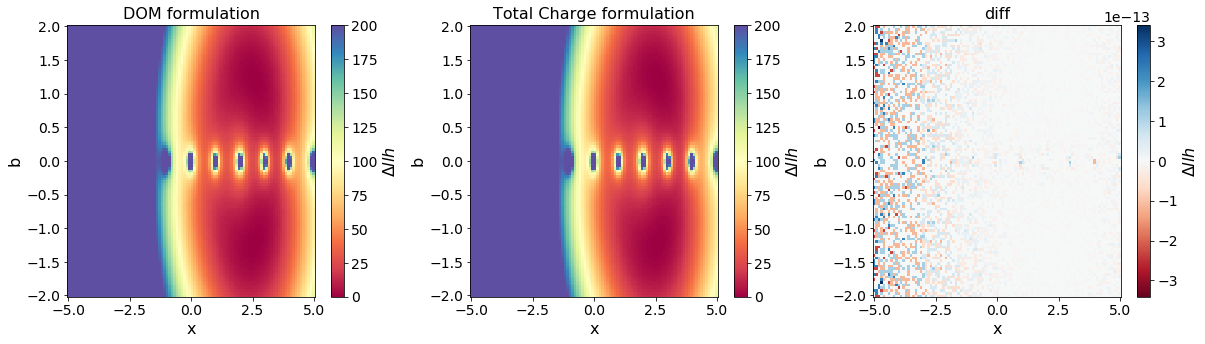

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

vmax=200

g['dom_llh'].plot(ax=ax[0], cmap='Spectral', cbar=True, vmax=vmax, label=r'$\Delta llh$')
ax[0].set_title('DOM formulation')
g['total_charge_llh'].plot(ax=ax[1], cmap='Spectral', cbar=True, vmax=vmax, label=r'$\Delta llh$')
ax[1].set_title('Total Charge formulation')
diff = g['dom_llh'] - g['total_charge_llh']
diff.plot(ax=ax[2], cmap='RdBu', cbar=True, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), label=r'$\Delta llh$')
ax[2].set_title('diff')

# Train NNs

In [10]:
%%time
# generate some MC (it's very slow right now, but I don't mind)
events = toy_experiment.generate_events(int(1e5), N_lims=(0, 20))

CPU times: user 13min 50s, sys: 2.35 s, total: 13min 52s
Wall time: 13min 51s


In [11]:
mc, truth = events

Prepare Data for NN

In [12]:
charges = []
for item in mc:
    charges.append(item[0])

In [13]:
charges = np.concatenate(charges)

In [14]:
theta = np.repeat(truth, len(toy_experiment.detector_xs), axis=0)

In [15]:
charges.shape

(1100000, 3)

In [16]:
theta.shape

(1100000, 3)

In [17]:
#np.save("charges_test.npy", charges)
#np.save("charges_test_truths.npy", theta)

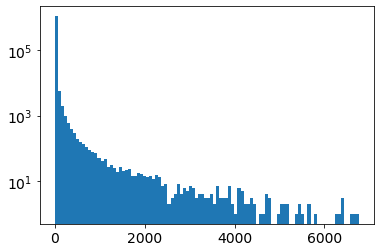

In [18]:
plt.hist(charges[:,0], bins=100)
plt.gca().set_yscale('log')

In [19]:
#charges = np.load('charges_test.npy')
#theta = np.load('charges_test_truths.npy')

In [20]:
def get_dataset(x, t, shuffle_block_size=2**15, batch_size=2**12, test=False):
        '''
        get a tensorflow dataset for likelihood approximation
        
        Parameters:
        -----------
        x : ndarray
            observations
        t : ndarray
            parameters        
        shuffle_block_size : int
            block size over which to shuffle, should be multiple of batch_size
        batch_size : int
        test : bool
            no shuffling, prefetching and caching
        
        Returns:
        --------
        
        tf.data.Dataset
            with structure ((x, t), y) for training
        
        '''
        
        N = x.shape[0]
        assert t.shape[0] == N
        
        d_x = tf.data.Dataset.from_tensor_slices(x)
        d_t = tf.data.Dataset.from_tensor_slices(t)

        d_true_labels = tf.data.Dataset.from_tensor_slices(np.ones((N, 1), dtype=x.dtype))
        d_false_labels = tf.data.Dataset.from_tensor_slices(np.zeros((N, 1), dtype=x.dtype))

        d_xs = tf.data.Dataset.from_tensor_slices([d_x, d_x]).interleave(lambda x : x)
        d_ts = tf.data.Dataset.from_tensor_slices([d_t, d_t.shuffle(shuffle_block_size)]).interleave(lambda x : x)
        d_ys = tf.data.Dataset.from_tensor_slices([d_true_labels, d_false_labels]).interleave(lambda x : x)
        
        
        dataset = tf.data.Dataset.zip((tf.data.Dataset.zip((d_xs, d_ts)), d_ys))
  
        return dataset.batch(batch_size)

In [21]:
x_train, x_test, t_train, t_test = train_test_split(charges, theta, test_size=0.2, random_state=42)

In [22]:
d_train = get_dataset(x_train, t_train)
d_test = get_dataset(x_test, t_test, test=True)

In [23]:
class trafo(tf.keras.layers.Layer):

    def call(self, charges, theta):

        r2 = tf.math.square(theta[:,0] - charges[:,1]) + tf.math.square(theta[:,1])
        
        out = tf.stack([
                 charges[:,0],
                 charges[:,1],
                 charges[:,2],
                 r2,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )    
            
        return out

In [24]:
#activation=tfa.activations.mish
activation='relu'

x_input = tf.keras.Input(shape=(x_train.shape[1],))
t_input = tf.keras.Input(shape=(t_train.shape[1],))

h = trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 7)            0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           256         trafo[0][0]                      
______________________________________________________________________________________________

In [25]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [26]:
hist = model.fit(d_train, epochs=20, verbose=1, validation_data=d_test)

Epoch 1/20
430/430 [==============================] - 7s 17ms/step - loss: 0.5741 - val_loss: 0.5277
Epoch 2/20
430/430 [==============================] - 8s 19ms/step - loss: 0.5319 - val_loss: 0.5230
Epoch 3/20
430/430 [==============================] - 9s 21ms/step - loss: 0.5284 - val_loss: 0.5232
Epoch 4/20
430/430 [==============================] - 9s 21ms/step - loss: 0.5259 - val_loss: 0.5218
Epoch 5/20
430/430 [==============================] - 9s 21ms/step - loss: 0.5239 - val_loss: 0.5201
Epoch 6/20
430/430 [==============================] - 9s 20ms/step - loss: 0.5233 - val_loss: 0.5205
Epoch 7/20
430/430 [==============================] - 9s 21ms/step - loss: 0.5224 - val_loss: 0.5207
Epoch 8/20
430/430 [==============================] - 9s 20ms/step - loss: 0.5225 - val_loss: 0.5189
Epoch 9/20
430/430 [==============================] - 9s 20ms/step - loss: 0.5215 - val_loss: 0.5204
Epoch 10/20
430/430 [==============================] - 9s 21ms/step - loss: 0.5215 - val_lo

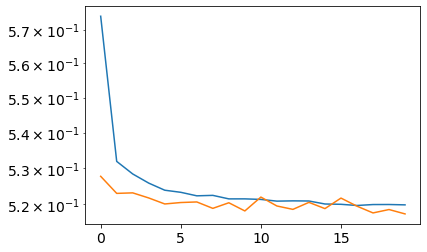

In [27]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.gca().set_yscale('log')

In [28]:
linmodel = tf.keras.models.clone_model(model)
linmodel.set_weights(model.get_weights())
linmodel.layers[-1].activation = tf.keras.activations.linear
linmodel.compile()

In [30]:
# some nasty gymnastics to get the NN inputs for the grid scan
tt = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
tts = np.repeat(tt, len(toy_experiment.detector_xs), axis=0)

xxs = np.repeat(test_event[0][np.newaxis,:, :], np.prod(g.shape), axis=0)
xxs = xxs.reshape(-1, 3)

In [31]:
llhs = linmodel.predict([xxs, tts])    

In [32]:
g['llh'] = -np.sum(llhs.reshape(-1, len(toy_experiment.detector_xs)), axis=1).reshape(g.shape)
g['llh'] -= np.min(g['llh'])

Text(0.5, 1.0, 'diff')

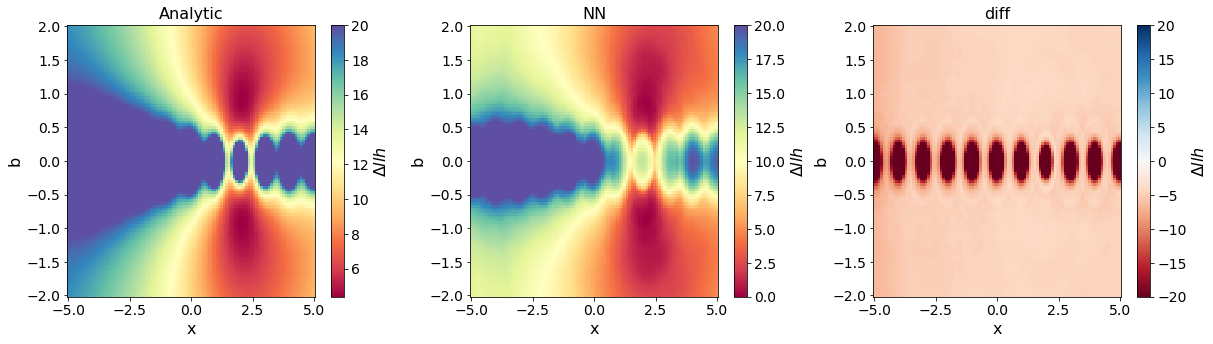

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

vmax=20

g['dom_charge_terms'].plot(ax=ax[0], cmap='Spectral', cbar=True, vmax=vmax, label=r'$\Delta llh$')
ax[0].set_title('Analytic')
g['llh'].plot(ax=ax[1], cmap='Spectral', cbar=True, vmax=vmax, label=r'$\Delta llh$')
ax[1].set_title('NN')
(g['llh'] - g['dom_charge_terms']).plot(ax=ax[2], cmap='RdBu', cbar=True, vmin=-20, vmax=20, label=r'$\Delta llh$')
ax[2].set_title('diff')

#plt.savefig('DOMnet_test.png', bbox_inches='tight')